In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
import pandas as pd
import numpy as np

ratings_list = [i.strip().split("::") for i in open('ratings.dat', 'r').readlines()]
# users_list = [i.strip().split("::") for i in open('/Users/spearpanda/Dropbox/CS6501TextMining/final project/matrix_factorization_recommenders/ml-1m/users.dat', 'r').readlines()]
movies_list = [i.strip().split("::") for i in open('hotels.dat', 'r',encoding = "ISO-8859-1").readlines()]

ratings = np.array(ratings_list)
# users = np.array(users_list)
movies = np.array(movies_list)

ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'HotelID', 'Rating'], dtype = int)
movies_df = pd.DataFrame(movies_list, columns = ['HotelID', 'Hotel'])
movies_df['HotelID'] = movies_df['HotelID'].apply(pd.to_numeric)

movies_df.head()

,HotelID,Hotel
0,595373,595373
1,754229,754229
2,100610,100610
3,264605,264605
4,609500,609500


In [3]:
ratings_df.head()

,UserID,HotelID,Rating
0,1,595373,2
1,2,595373,5
2,3,595373,4
3,4,595373,2
4,5,595373,5


In [16]:
R_df = ratings_df.pivot_table(index = 'UserID', columns ='HotelID', values = 'Rating').fillna(0)
R_df.head()

HotelID,72572,72579,72586,73718,73727,73739,73757,73787,73799,73821,...,1095744,1119270,1126079,1127236,1159023,1159881,1163894,1166502,1191442,1225375
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
R = R_df.values
R.shape

(148480, 1850)

In [6]:
class MF():
    
    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.
        
        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """
        
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        print('Start Training')
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
#         print(self.P)
#         print(self.Q)
        print('Finish Initialize user and item latent feature matrice')
        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        print('Finish Initialize the biases')
        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
#         print(self.samples)
        
        print('Finish Create a list of training samples')
        # Perform stochastic gradient descent for number of iterations
        training_process = []
        for i in range(self.iterations):
#             print("Iteration {}".format(str(i)))
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            if (i+1) % 2 == 0:
                training_process.append((i, mse))
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
        
        return training_process

    def mse(self):
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])
            
            # Create copy of row of P since we need to update it but use older values for update on Q
            P_i = self.P[i, :][:]
            
            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * P_i - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        if math.isnan(prediction):
            print(i, j, prediction, self.b, self.b_u[i], self.b_i[j], self.P[i, :].dot(self.Q[j, :].T))
        return prediction
    
    def full_matrix(self):
        return mf.b + mf.b_u[:,np.newaxis] + mf.b_i[np.newaxis:,] + mf.P.dot(mf.Q.T)


In [17]:
print(R.shape)
trainings = []
Ks = (5, 10, 20, 50, 100, 200)
for k in Ks:
    mf = MF(R, K=k, alpha=0.03, beta=0.01, iterations=60)
    training_process = mf.train()
    trainings.append(training_process)
    print("Predicted Matrix:")
    print(mf.full_matrix())

(148480, 1850)
Start Training
Finish Initialize user and item latent feature matrice
Finish Initialize the biases


KeyboardInterrupt: 

K = 5 Error = 46.24162270364638
K = 10 Error = 31.725631732396455
K = 20 Error = 21.161327816013962
K = 50 Error = 16.031213565351234
K = 100 Error = 16.033958260288696
K = 200 Error = 16.13359334770292


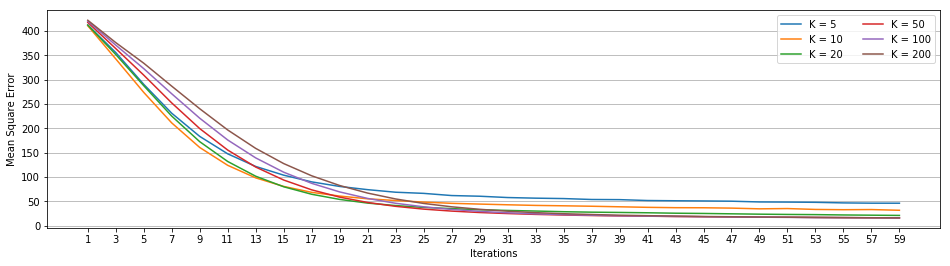

In [8]:
plt.figure(figsize=((16,4)))
count = 0
for training_process in trainings:
    x = [x for x, y in training_process]
    y = [y for x, y in training_process]
    plt.plot(x, y,label="K = {}".format(str(Ks[count])))
    print("K = {}".format(str(Ks[count])), 'Error = {}'.format(str(training_process[-1][1])))
    count+=1
plt.xticks(x, x)
plt.legend(loc=1, ncol=2)
plt.xlabel("Iterations")
plt.ylabel("Mean Square Error")
plt.grid(axis="y")

In [18]:
mf = MF(R, K=50, alpha=0.03, beta=0.01, iterations=60)
training_process = mf.train()
trainings.append(training_process)
print("Predicted Matrix:")
print(mf.full_matrix())

Start Training
Finish Initialize user and item latent feature matrice
Finish Initialize the biases


KeyboardInterrupt: 

In [10]:
all_user_predicted_ratings = mf.full_matrix()
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

HotelID,72572,72579,72586,73718,73727,73739,73757,73787,73799,73821,...,1095744,1119270,1126079,1127236,1159023,1159881,1163894,1166502,1191442,1225375
0,3.677372,3.006041,3.167006,2.979360,2.605478,3.165077,3.004518,2.677394,3.228869,3.602822,...,3.645246,3.035568,4.028179,2.215916,3.383904,3.644269,3.674344,3.718127,3.426174,2.803246
1,4.572363,3.479316,3.966790,3.767270,3.389973,3.966847,3.737502,3.070433,3.810523,4.306615,...,4.403701,3.640332,5.115978,2.720327,4.129407,4.569432,4.910272,4.725409,3.912274,4.289988
2,4.214443,3.278341,3.621385,3.441999,3.150148,3.705818,3.435656,2.923415,3.485139,4.120418,...,4.062498,3.470533,4.795273,2.541617,3.875727,4.268296,4.497402,4.398039,3.748956,3.709966
3,3.674001,2.982015,3.112945,2.977456,2.645101,3.193935,2.996427,2.609625,3.208868,3.618996,...,3.683503,3.037042,4.042696,2.172435,3.414250,3.639927,3.667054,3.693765,3.442929,2.772716
4,4.507971,3.545321,3.954639,3.841448,3.525679,4.040848,3.736319,3.253783,3.813063,4.505661,...,4.474881,3.731751,5.239051,2.831428,4.123790,4.625623,4.959832,4.855899,4.076121,4.267780


In [11]:
def recommend_hotels(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    print(sorted_user_predictions)
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.UserID == (userID)]
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'HotelID', right_on = 'HotelID').
                     sort_values(['Rating'], ascending=False))

    print ('User {0} has already rated {1} hotels.'.format(userID, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings hotels not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating HotelID that the user hasn't seen yet.
    recommendations = (movies_df[~movies_df['HotelID'].isin(user_full['HotelID'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index()).
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [12]:
rated, predictions = recommend_hotels(preds_df, 160, hotel_df, ratings_df, 10, 'New_York_City_New_York')

HotelID
602600     5.338718
289019     5.177248
580687     5.139207
595594     5.131988
603376     5.110669
325634     5.091944
223120     5.079397
236048     5.069375
224856     5.057176
224250     5.056616
98727      5.052154
1126079    5.050787
73727      5.048797
601550     5.047902
74583      5.042822
195943     5.041494
456987     5.041284
299764     5.037661
187737     5.037259
307375     5.035062
112179     5.034724
268507     5.025706
651045     5.024993
218544     5.021951
575999     5.018794
572190     5.017924
77629      5.016890
302434     5.015443
309351     5.015174
82116      5.014209
             ...   
301803     1.400935
306175     1.382633
234000     1.374199
305273     1.298284
77264      1.298281
111983     1.294762
90017      1.292689
305520     1.199512
306174     1.199290
230717     1.181717
736553     1.157881
237585     1.152373
73855      1.127449
146826     1.082572
197790     1.081430
564652     1.054555
89033      1.052063
224866     1.041115
255651     1

In [13]:
rated.head(10)

,UserID,HotelID,Rating,Hotel
20362,160,556833,5,556833
19161,160,230103,5,230103
8267,160,265072,5,265072
8268,160,265072,5,265072
8269,160,265072,5,265072
8271,160,265072,5,265072
8272,160,265072,5,265072
8273,160,265072,5,265072
19163,160,231637,5,231637
19162,160,231637,5,231637


In [14]:
predictions

,HotelID,Hotel
127,602600,602600
364,580687,580687
381,1126079,1126079
246,581477,581477
355,99762,99762
341,604488,604488
63,229137,229137
164,514340,514340
7,735480,735480
298,307368,307368
